# Автокодировщики на примере MNIST

Объект описывается слишком большим количеством признаков? Хочется уменьшить их чилсло и не потерять важную информацию? Вам надоел PCA? Тогда автокодировщики вам подойдут! 

### Почиташки 

* [Хорошая серия статей](https://habrahabr.ru/post/331382/) про автокодировщики, взятая как база для скрипта. В статье всё делалось на примере цифр. В этом блокноте своё отражение получили первые две статьи серии. 
* [Глава книги](http://www.deeplearningbook.org/contents/autoencoders.html) deep learning book, на которой основана статья выше. 
* [Статья из блока про Keras](https://blog.keras.io/building-autoencoders-in-keras.html), на которой также основана статья выше. 
* [Неделя 4 курса Introduction to deep learning](https://www.coursera.org/learn/intro-to-deep-learning/home/week/4), с которой также взята часть материалов, и на которой я являюсь ментором. 

Эпоха больших данных даёт нам слишком много данных. Часто хочется, чтобы их было немного поменьше, но при этом они выражали бы всю информацию о великом процессе порождения данных более ёмко. Не потерять в знании, но сэкономить! Именно из такого благородного помысла рождается метод главных компонент. Его посыл очень прост: давайте посмотрим на наши данные, найдём в них те направления, в которых происходит самое сильное изменение и оставим только их. При этом, в плане информации мы бы не потеряли особо много. Именно так часто поступают в случае, когда размерность данных очень большая. Находят $d$ Направлений, разброс в которых покрывает $90\%$ дисперсии, а остальное забывают. 

Например, если у нас есть выборка из карасей и щук и требуется научится отличать одних от ругих, то мы могли бы оставить только информацию о чешуйках, расположенных вдоль первой, более длинной компоненты. На качество нашего классификатора это бы повлияло слабо, но мы, при этом, избавились бы от лишней размерности, от оценки лишнего коэфициента и могли бы пустить большее число наблюдений на оценку меньшего числа параметров.  

![](https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/PCA_fish.png/256px-PCA_fish.png)

Главная фишка метода главных компонент состоит в том, что он делает всю эту редукцию линейно. На самом деле все новые признаки будут представлять из себя линейные комбинации из старых. 

Идею такой редукции лишней информации можно обобщить до нелинейного случая и сделать прыжок к нейросетям, которые называются **автоэнокдерами.**  Автоэнкодеры учатся оставлять минимум информации так, чтобы по этому минимуму было возможно восстановить с очень высокой точностью исходную информацию. 

Автоэнкодеры — это нейронные сети прямого распространения, которые восстанавливают входной сигнал на выходе. Внутри у них имеется скрытый слой, который представляет собой код, описывающий модель. Автоэнкодеры конструируются таким образом, чтобы не иметь возможность точно скопировать вход на выходе. Обычно их ограничивают в размерности кода. 

![](https://hsto.org/web/cf6/228/613/cf6228613fdc4f8fb819cbd41bb677eb.png) 

Закодированную часть Входной сигнал восстанавливается с ошибками из-за потерь при кодировании, но, чтобы их минимизировать, сеть вынуждена учиться отбирать наиболее важные признаки.

Новый пример! Пусть у нас есть куча рукописных цифр и мы хотели бы научить компьютер понимать где какая цифра нарисована. Каждая цифра это картинка из пикселей размер $28 \times 28$. Всего у нас $28^2$ наблюдаемые переменные. Это слишком много! Явно не каждый пиксель несёт в себе информацию о том какая цифра нарисована на картинке. Большая часть пикселей бесполезна. 

Чтобы отобрать самые важные нелинейные комбинации из пикселей, мы можем сделать следующее: 

![](https://blog.keras.io/img/ae/autoencoder_schema.jpg)

Нейросеть получает на вход цифру, пытается оставить 10 самых важных нейлинейных комбинаций из пикселей, а после по этим самым важным комбинациям, она пытается восстановить цифру назад с как можно большей точностью. Ограничение на то сколько самых важных нелинейных пикселей должно остаться, заставляет нашу сетку стараться отобрать исключительно всё самое важное, что можно найти на картинке. Метод главных компонент будет частным, самым простым случаем, такой нейронной сетки. 

Первая часть автокодировщика $g(x)$ называется **encoder**. Она пытается закодировать картинку. Вторая часть $f(h)$ называет **decoder**. Она пытается раскодировать картинку. Автоэккодер, изменяя $f$ и $g$ пытается выучить тождественную функцию 

$$x = f(g(x)),$$ 

минимизируя какой-то функционал ошибки 

$$L(x, f(g(x))).$$ 

При этом выучить тождественную выборку он не может, так как в сердцевине находится  **бутылочное горлышко** с довольно маленьким числом нейронов. В итоге сетка вынуждена отаравлять в сердцевину только те комбинации фичей, по которым легче всего восстановить входные данные, и таким образом отсеивает ненужную информацию. В горлышке в результате обучения оказываются наши новые нелинейные фичи. Попробуем собрать подобный кодировщик для чисел из набора MNIST. 

## 1. Смотрим на данные

Подгружаем данные и нормируем их по уже знакомой нам формуле. 

$$
x_{norm} = \frac{x}{255}
$$



In [1]:
from keras.datasets import mnist
import numpy as np
import keras
import keras, keras.layers as L

(X_train, y_train), (X_test, y_test) = mnist.load_data()

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
# делай раз
X_train = X_train/255
X_test =  X_test/255
X_train = np.reshape(X_train, (len(X_train), 28, 28, 1))  # Оставляем одну размерность на число каналов
X_test = np.reshape(X_test, (len(X_test), 28, 28, 1))     
img_shape = X_train[0].shape

# делай два! 
y_train = keras.utils.to_categorical(y_train,10)
y_test = keras.utils.to_categorical(y_test,10)
# Размерность после конвертации будет вот такой: (?, NUM_CLASSES)

In [3]:
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


Нарисуем несколько рандомных картинок из обучающей выборки! 

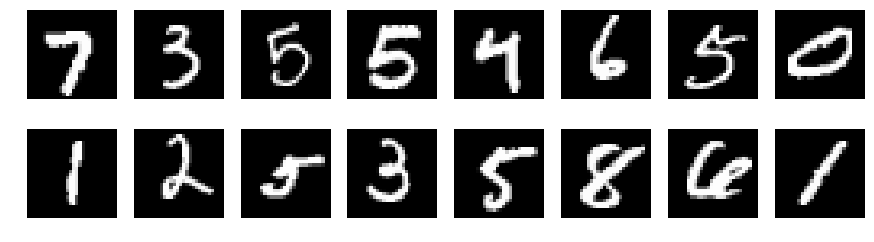

In [4]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(X_train[random_index, :, :, 0], cmap = 'gray')
plt.show()

## 2. Собираем автокодировщик для PCA 

Как мы уже выяснили, простейшим автокодировщиком является PCA. Один слой на входе, бутылочное горлышко с новыми фичами, один слой на выходе и PCA готов. 

In [5]:
def build_pca_autoencoder(img_shape, code_size=36):
    # code_size это размерность кодированного представления (фичей на выходе)
    
    # Энкодер 
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape)) # Входной слой размерность будет 28 28 1 
    encoder.add(L.Flatten())             # Вспомогательный слой решейпинга 
    encoder.add(L.Dense(code_size))      # Обратите внимание, что нет активации 
    
    # Декодер 
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,))) # Принимаем закодированное представление на вход
    decoder.add(L.Dense(np.prod(img_shape)))
    decoder.add(L.Reshape(img_shape))
    return encoder,decoder

Осталось только собрать модель.

In [6]:
# Сконструировали энкодер и декодер 
encoder, decoder = build_pca_autoencoder(img_shape, code_size=36)

inp = L.Input(img_shape)  # Вход
code = encoder(inp)       # Энкодер от входа 
reconstruction = decoder(code)  # Декодер от кода 

# Автоэнокодер от входа и выхода 
autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse') # Собираем сеть с методом оптимизации и выбранной ошибкой 
# Посмотрим на параметры 
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 36)                28260     
_________________________________________________________________
sequential_2 (Sequential)    (None, 28, 28, 1)         29008     
Total params: 57,268
Trainable params: 57,268
Non-trainable params: 0
_________________________________________________________________


Обучаем модель. 

In [7]:
# Обучаем модель 
hist_1 = autoencoder.fit(x = X_train, y = X_train,  # Обратите внимание что энкодер восстанавливает вход на выходе 
                epochs = 50,                 # Никакие y тут не нужны. Это просто лэйблы... 
                batch_size = 256,
                shuffle = True,
                validation_data = [X_test, X_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 31us/step - loss: 0.0437 - val_loss: 0.0271
Epoch 2/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0234 - val_loss: 0.0203
Epoch 3/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0193 - val_loss: 0.0178
Epoch 4/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.0174 - val_loss: 0.0165
Epoch 5/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0166 - val_loss: 0.0160
Epoch 6/50
60000/60000 [==============================] - 2s 25us/step - loss: 0.0162 - val_loss: 0.0157
Epoch 7/50
60000/60000 [==============================] - 2s 28us/step - loss: 0.0161 - val_loss: 0.0156
Epoch 8/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0160 - val_loss: 0.0155
Epoch 9/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0159 - val_loss: 0.0155
Epoch

Наш автокодировщик обучился. это довольно приятная новость. Попробуем отрисовать оригинальные цифры, их компактные представления и то как по этим представлениям цифры восстанавливаются. 

In [8]:
# Функция для отрисовки ооигинальных цифр, их представления и восстановленного рисунка
def visualize(img,encoder,decoder):
    code = encoder.predict(img[None])[0]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    plt.imshow(img.reshape(28,28), cmap = 'gray')

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    plt.imshow(reco.clip(0,1).reshape(28,28), cmap = 'gray')
    plt.show()

Final MSE: 0.015342104893922806


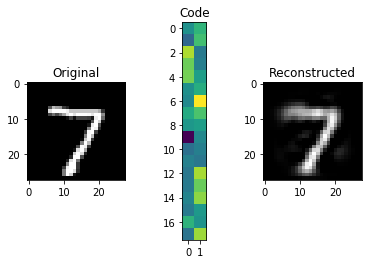

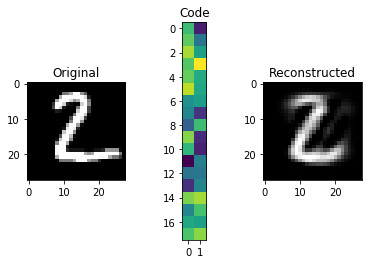

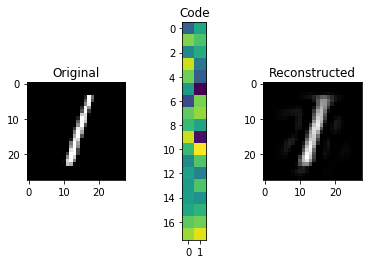

In [9]:
score = autoencoder.evaluate(X_test, X_test,verbose=0)
print("Final MSE:",score)

for i in range(3):
    img = X_test[i]
    visualize(img,encoder,decoder)

Теперь по оставшимся 36 фичам (вместо оригинальных 784) можно строить классификаторы. Попробуйте на досуге заняться этим весёлым занятием, а мы движемся дальше. 

## 3 Глубокий автоэнкодер 

Всегда можно лучше! Сконструируем глубокий автокодировщик для вычленения нелинейных фичей. 

![ ](https://pbs.twimg.com/media/CYggEo-VAAACg_n.png:small)

* Обратите внимание, что при постройке автокодировщика не должно быть слоёв меньших, чем бутылочное горлышко (выход энкодера). 
* Также обратите внимание, что вполне уместно использовать свёртки и пулинг, но такой автокодировщик будет построен чуточку ниже. 

In [10]:
def build_deep_autoencoder(img_shape, code_size=36):
    # code_size это размерность кодированного представления 
    
    # Энкодер 
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape)) # Входной слой размерность будет 28 28 1 
    encoder.add(L.Flatten()) # Вспомогательный слой решейпинга 
    # Слои глубокого энкодера 
    encoder.add(L.Dense(code_size*2, activation='relu'))
    encoder.add(L.Dense(code_size, activation='linear')) # Бутылочное горлышко
    
    # Декодер 
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,))) # Принимаем закодированное представление на вход
    # Слои глубокого декодирования
    decoder.add(L.Dense(code_size*2, activation='relu'))  # Обратите внимание, что слои идут в обратном порядке
    decoder.add(L.Dense(np.prod(img_shape))) # Развёртываем картинку 
    decoder.add(L.Reshape(img_shape))
    return encoder,decoder

# Сконструировали энкодер и декодер 
encoder,decoder = build_deep_autoencoder(img_shape,code_size=36)

inp = L.Input(img_shape)        # Вход
code = encoder(inp)             # Энкодер от входа 
reconstruction = decoder(code)  # Декодер от кода 

# Автоэнокодер от входа и выхода 
autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax',loss='mse') # Собираем сеть с методом оптимизации и выбранной ошибкой 

# Посмотрим на параметры 
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_3 (Sequential)    (None, 36)                59148     
_________________________________________________________________
sequential_4 (Sequential)    (None, 28, 28, 1)         59896     
Total params: 119,044
Trainable params: 119,044
Non-trainable params: 0
_________________________________________________________________


Число параметров выросло, посмотрим, справится ли новая модель лучше:

In [11]:
# Обучаем модель 
hist_2 = autoencoder.fit(x = X_train, y = X_train,  # Обратите внимание что энкодер восстанавливает вход на выходе 
                epochs = 50,                 # Никакие y тут не нужны. Это просто лэйблы... 
                batch_size = 256,
                shuffle = True,
                validation_data=[X_test, X_test])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 38us/step - loss: 0.0451 - val_loss: 0.0288
Epoch 2/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.0258 - val_loss: 0.0230
Epoch 3/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.0219 - val_loss: 0.0204
Epoch 4/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.0199 - val_loss: 0.0187
Epoch 5/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.0184 - val_loss: 0.0174
Epoch 6/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.0175 - val_loss: 0.0167
Epoch 7/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.0169 - val_loss: 0.0162
Epoch 8/50
60000/60000 [==============================] - 2s 35us/step - loss: 0.0165 - val_loss: 0.0160
Epoch 9/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.0163 - val_loss: 0.0159
Epoch

Особо сильно уменьшить не получилось. Можно поколдовать с архитектурой и добиться улучшения. 

Final MSE: 0.013519022335112095


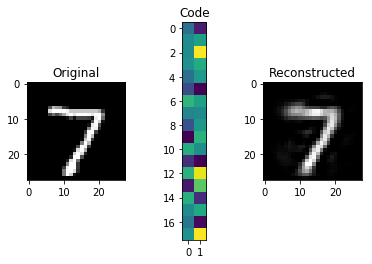

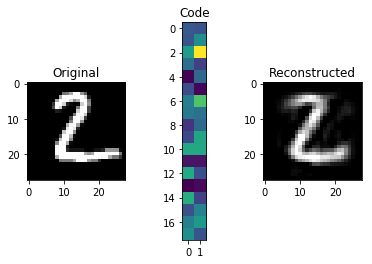

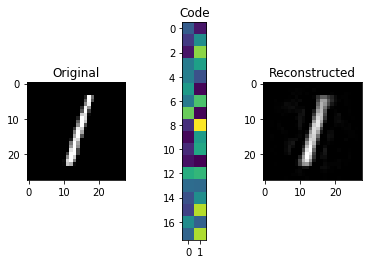

In [12]:
score = autoencoder.evaluate(X_test, X_test,verbose=0)
print("Final MSE:",score)

for i in range(3):
    img = X_test[i]
    visualize(img,encoder,decoder)

## 4. Свёрточный автокодировщик 

Добавим свёрточные слои и немного макспулинга. Это позволит сделать автокдировщик инвариантным к расположению цифр в пространстве. 

In [17]:
def build_conv_autoencoder(img_shape, code_size=36):
    # code_size это размерность кодированного представления 
    
    # Энкодер 
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape)) # Входной слой размерность будет 28 28 1 
    encoder.add(L.Conv2D(64, kernel_size=(6,6),activation='relu',padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2,2),padding='same'))
    encoder.add(L.Conv2D(16, kernel_size = (2,2),activation='relu',padding='same'))
    encoder.add(L.MaxPooling2D(pool_size=(2,2),padding='same'))
    encoder.add(L.Conv2D(1, kernel_size = (6,6), activation = 'relu', padding='same'))
    # На этом моменте представление  (6, 6, 1) т.е. 36-размерное
       
    # Декодер 
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((6, 6, 1))) # Принимаем закодированное представление на вход (РАЗМЕРНОСТЬ!)
    decoder.add(L.Conv2D(16, kernel_size= (6,6), activation='relu', padding='same'))
    decoder.add(L.UpSampling2D((2,2)))
    decoder.add(L.Conv2D(64, kernel_size = (2,2), activation='relu', padding='same'))
    decoder.add(L.UpSampling2D((2,2)))
    decoder.add(L.Conv2D(1,kernel_size =(6,6), padding='same', activation='sigmoid'))
    return encoder,decoder


# Сконструировали энкодер и декодер 
encoder,decoder = build_conv_autoencoder(img_shape,code_size=36)

inp = L.Input(img_shape)  # Вход
code = encoder(inp)       # Энкодер от входа 
reconstruction = decoder(code)  # Декодер от кода 

# Автоэнокодер от входа и выхода 
autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax',loss='mse') # Собираем сеть с методом оптимизации и выбранной ошибкой 
# Посмотрим на параметры 
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 7, 7, 1)           7057      
_________________________________________________________________
sequential_8 (Sequential)    multiple                  7057      
Total params: 14,114
Trainable params: 14,114
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Модель будет обучаться ну оооочень долго (около 30 минут)... 
# Ошибка падает довольно быстро, добавлять свёртку было хорошей идеей
hist_3 = autoencoder.fit(X_train, X_train,
                        epochs=5,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(X_test, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 298s 5ms/step - loss: 0.1140 - val_loss: 0.1140
Epoch 2/5
60000/60000 [==============================] - 311s 5ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 3/5
60000/60000 [==============================] - 328s 5ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 4/5
60000/60000 [==============================] - 296s 5ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 5/5
60000/60000 [==============================] - 315s 5ms/step - loss: 0.1120 - val_loss: 0.1140


In [42]:
score = autoencoder.evaluate(X_test, X_test,verbose=0)
print("Final MSE:",score)

Final MSE: 0.0028039395201951266


Посмотрим на картинки. Нужно убедиться, что наши сетки сошлись. 

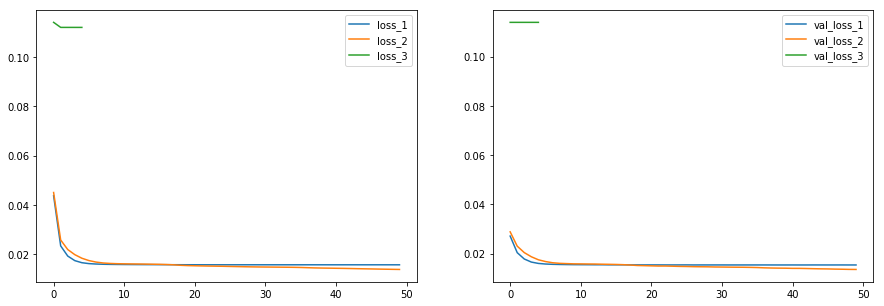

In [30]:
start = 0
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(hist_1.history['loss'][start:])
plt.plot(hist_2.history['loss'][start:])
plt.plot(hist_3.history['loss'][start:])
plt.legend(['loss_1','loss_2','loss_3'])

plt.subplot(122)
plt.plot(hist_1.history['val_loss'][start:])
plt.plot(hist_2.history['val_loss'][start:])
plt.plot(hist_3.history['val_loss'][start:])
plt.legend(['val_loss_1','val_loss_2','val_loss_3'])

Могу сказать только одно: хмммм

## 5. Denoising автоэнкодер 

Автоэнкодеры можно обучить убирать шум из данных: для этого надо на вход подавать зашумленные данные и на выходе сравнивать с данными без шума. Создадим модель, которая будет зашумлять входное изображение, а после пытаться избавить его от шума. 

In [31]:
# Добавляем на картинку немного шума 
def apply_gaussian_noise(X,sigma=0.01):
    return X + sigma*np.random.normal(loc=0.0, scale=1.0, size=X.shape) 

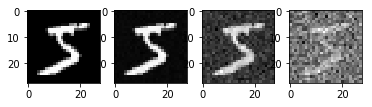

In [32]:
plt.subplot(1,4,1)
plt.imshow(X_train[0].reshape(28,28), cmap = 'gray')
plt.subplot(1,4,2)
plt.imshow(apply_gaussian_noise(X_train[:1],sigma=0.01)[0].reshape(28,28), cmap = 'gray')
plt.subplot(1,4,3)
plt.imshow(apply_gaussian_noise(X_train[:1],sigma=0.1)[0].reshape(28,28), cmap = 'gray')
plt.subplot(1,4,4)
plt.imshow(apply_gaussian_noise(X_train[:1],sigma=0.5)[0].reshape(28,28), cmap = 'gray')

In [33]:
# Зашумляем данные 
X_train_noisy = apply_gaussian_noise(X_train, sigma=0.1)
X_test_noisy = apply_gaussian_noise(X_test, sigma=0.1)

# Убираем все заскоки за отрезок [0;1]
X_train_noisy = np.clip(X_train_noisy, 0., 1.)
X_test_noisy = np.clip(X_test_noisy, 0., 1.)

Собираем сеточку из предыдущего пункта.

In [34]:
# Размер у горлышка как у входа, соответствует 28**2
encoder,decoder = build_deep_autoencoder(img_shape,code_size=512)

inp = L.Input(img_shape)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp,reconstruction)
autoencoder.compile('adamax','mse')

autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
sequential_9 (Sequential)    (None, 512)               1328640   
_________________________________________________________________
sequential_10 (Sequential)   (None, 28, 28, 1)         1328912   
Total params: 2,657,552
Trainable params: 2,657,552
Non-trainable params: 0
_________________________________________________________________


In [35]:
hist_noise = autoencoder.fit(X_train_noisy, X_train,
                        epochs=50,
                        batch_size=256,
                        shuffle=True,
                        validation_data=(X_test_noisy, X_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 17s 285us/step - loss: 0.0244 - val_loss: 0.0115
Epoch 2/50
60000/60000 [==============================] - 18s 307us/step - loss: 0.0096 - val_loss: 0.0080
Epoch 3/50
60000/60000 [==============================] - 19s 317us/step - loss: 0.0073 - val_loss: 0.0066
Epoch 4/50
60000/60000 [==============================] - 18s 308us/step - loss: 0.0062 - val_loss: 0.0058
Epoch 5/50
60000/60000 [==============================] - 20s 341us/step - loss: 0.0055 - val_loss: 0.0052
Epoch 6/50
60000/60000 [==============================] - 17s 277us/step - loss: 0.0051 - val_loss: 0.0049
Epoch 7/50
60000/60000 [==============================] - 18s 295us/step - loss: 0.0047 - val_loss: 0.0046
Epoch 8/50
60000/60000 [==============================] - 17s 289us/step - loss: 0.0045 - val_loss: 0.0044
Epoch 9/50
60000/60000 [==============================] - 18s 296us/step - loss: 0.0042 - val_

Final MSE: 0.002485318047553301


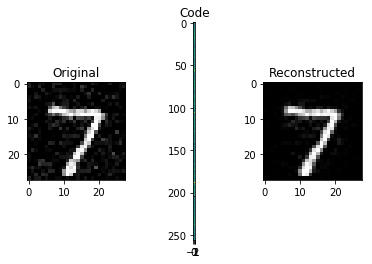

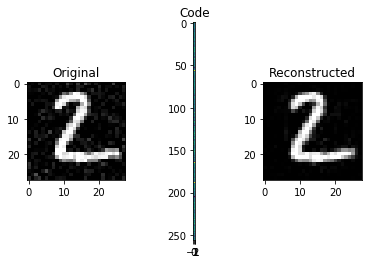

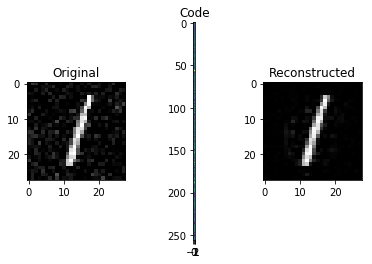

In [36]:
score = autoencoder.evaluate(X_test_noisy, X_test,verbose=0)
print("Final MSE:",score)

for i in range(3):
    img = X_test_noisy[i]
    visualize(img,encoder,decoder)

## 6. Побочные эффектики

Итак, если взять произвольное изображение цифры, большая часть пикселей на нём окажется бесполезной. С другой стороны, все изображения в некоторой окрестности этой цифры также можно считать подобной цифрой. На самом деле в пространстве всех изображений есть подпростоанство меньшей размерности в области вокруг которого сосредоточились все изображения цифр. Автоэнкодеры с размерностью $k$ пытаются найти $k$-мерное многообразие в пространстве объектов, которое наиболее полно передаёт все вариации в выборке. Сам код задаёт параметризацию этого многообразия. При этом энкодер сопоставляет объекту его параметр на многообразии, а декодер параметру сопоставляет точку в пространстве объектов.

Чем больше размерность кодов, тем больше вариаций в данных автоэнкодер сможет передать. Если размерность кодов слишком мала, автоэнкодер запомнит нечто среднее по недостающим вариациям в заданной метрике (это одна из причин, почему mnist цифры все более размытые при снижении размерности кода в автоэнкодерах).

Только что мы с вами обучили сеть, которая преобразует изображение само в себя несовершенным методом. Само по себе решение этой задачи является не особо полезным, однако оно может быть использовано для решения других задач. О том, что бутылочное горлышко мы можем использовать для обучения других моделей, мы уже говорили. Теперь посмотрим на то, как с помощью энкодеров можно искать похожести.

### 6.1 Поиск похожих изображений 

С помощью найденного многообразия можно искать похожие друг на друга изображения. Чтобы ускорить процесс поиска, мы будем использовать похожий на метод ближайших соседей, но более быстрый алгоритм под названием [Locality Sensitive Hashing forest.](http://scikit-learn.org/0.16/modules/generated/sklearn.neighbors.LSHForest.html)

In [37]:
images = X_train
codes = encoder.predict(images)
assert len(codes) == len(images)

In [38]:
from sklearn.neighbors import LSHForest
lshf = LSHForest(n_estimators=50).fit(codes)

/usr/local/lib/python3.6/site-packages/sklearn/neighbors/approximate.py:220: DeprecationWarning: LSHForest has poor performance and has been deprecated in 0.19. It will be removed in version 0.21.
  DeprecationWarning)


In [39]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = lshf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [51]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=11)
    
    plt.figure(figsize=[8,6])
    plt.subplot(3,4,1)
    plt.imshow(image.reshape(28,28), cmap = 'gray')
    plt.title("Original image")
    
    for i in range(11):
        plt.subplot(3,4,i+2)
        plt.imshow(neighbors[i].reshape(28,28), cmap = 'gray')
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

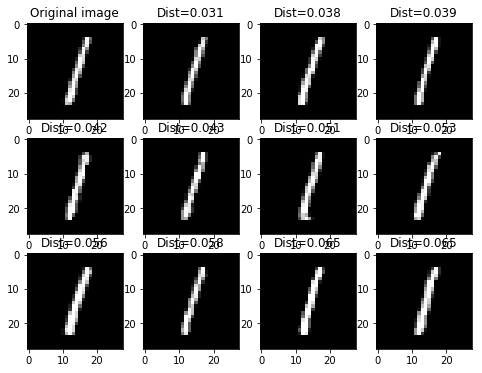

In [52]:
show_similar(X_test[2])

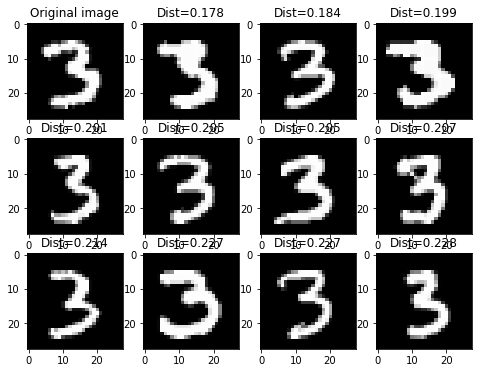

In [53]:
show_similar(X_test[500])

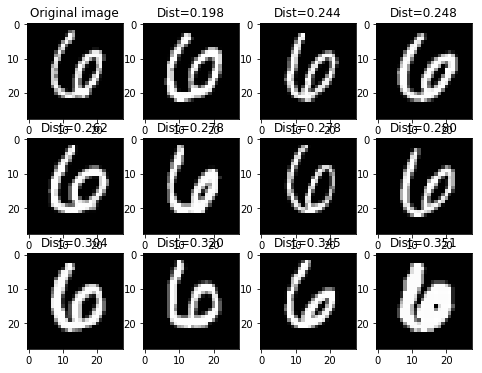

In [54]:
show_similar(X_test[66])

На этом мы пожалуй остановимся. В скрипте, который ждёт вас в качестве дз, вам придётся построить свой автокодировщик для человеческих лиц.